In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f"PyTorch version:{torch.__version__}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

PyTorch version:1.10.0+cu111
device : cuda:0


In [2]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Define Model
class RecurrentNeuralNetworkClass(nn.Module):
    def __init__(self, name='rnn', xdim=28, hdim=256, ydim=10, n_layer=3):
        super(RecurrentNeuralNetworkClass, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim # cell state dim, 
        self.ydim = ydim
        self.n_layer = n_layer

        self.rnn = nn.LSTM(
            input_size = self.xdim, hidden_size=self.hdim, num_layers=self.n_layer, batch_first=True
        )
        self.lin = nn.Linear(self.hdim, self.ydim)

    def forward(self,x):
        # set initial hidden and cell state
        h0 = torch.zeros(self.n_layer, x.size(0), self.hdim).to(device)
        c0 = torch.zeros(self.n_layer, x.size(0), self.hdim).to(device)
        #RNN
        rnn_out, (hh,cn) = self.rnn(x, (h0,c0))
        # x : [N * L * Q] -> rnn_out : [N * L * D]
        out = self.lin(rnn_out[:,-1,:]).view([-1,self.ydim])
        return out

R = RecurrentNeuralNetworkClass(
    name = 'rnn', xdim=28, hdim=256, ydim=10, n_layer=2).to(device)

loss = nn.CrossEntropyLoss()
optm = optim.Adam(R.parameters(), lr=1e-3)
print("Done")

Done


### Check How LSTM Works
- `N`: number of batches
- `L`: sequence lengh
- `Q`: input dim
- `K`: number of layers
- `D`: LSTM feature dimension

` Y,(hn,cn) = LSTM(X) `

- `X`: [N x L x Q] - `N` input sequnce of length `L` with `Q` dim. 
- `Y`: [N x L x D] - `N` output sequnce of length `L` with `D` feature dim.
- `hn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` feature dim. 
- `cn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` cell dim. 

In [4]:
from torchsummary import summary

In [5]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(R.named_parameters()):
    if param.requires_grad :
        param_numpy = param.detach().cpu ().numpy()
        n_param += len(param_numpy.reshape(-1))
        print(f"{p_idx} |  name : {param_name} | shape : {param_numpy.shape}")
        print(f".    val : {param_numpy.reshape(-1)[:5]}")
print(f"Total number of parameters : {format(n_param, ',d')}")

0 |  name : rnn.weight_ih_l0 | shape : (1024, 28)
.    val : [ 0.035  0.05  -0.044 -0.059 -0.016]
1 |  name : rnn.weight_hh_l0 | shape : (1024, 256)
.    val : [-0.05   0.024  0.057 -0.057 -0.046]
2 |  name : rnn.bias_ih_l0 | shape : (1024,)
.    val : [ 0.002 -0.016 -0.016 -0.008  0.047]
3 |  name : rnn.bias_hh_l0 | shape : (1024,)
.    val : [-0.047  0.005  0.012  0.038  0.002]
4 |  name : rnn.weight_ih_l1 | shape : (1024, 256)
.    val : [-0.014  0.032  0.024 -0.015 -0.032]
5 |  name : rnn.weight_hh_l1 | shape : (1024, 256)
.    val : [-0.056  0.032 -0.015  0.001  0.03 ]
6 |  name : rnn.bias_ih_l1 | shape : (1024,)
.    val : [ 0.021 -0.043  0.043  0.006  0.015]
7 |  name : rnn.bias_hh_l1 | shape : (1024,)
.    val : [ 0.022 -0.049  0.024  0.061 -0.026]
8 |  name : lin.weight | shape : (10, 256)
.    val : [ 0.05  -0.013  0.001  0.048  0.042]
9 |  name : lin.bias | shape : (10,)
.    val : [-0.015 -0.061  0.027  0.03  -0.054]
Total number of parameters : 821,770


In [6]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(3,20,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = R.forward(x_torch)
y_numpy = y_torch.detach().cpu().numpy()

print(f"x_numpy : {x_numpy.shape}")
print(f"y_numpy : {y_numpy.shape}")

x_numpy : (3, 20, 28)
y_numpy : (3, 10)


In [7]:
# eval function

def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0,0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_target = batch_out.to(device)
            model_pred = model(batch_in.view(-1,28,28).to(device))
            _,y_pred = torch.max(model_pred, 1)
            n_correct += (y_pred == y_target).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train()
    return val_accr

In [8]:
# init eval
train_accr = func_eval (R, train_iter, device)
test_accr = func_eval (R, test_iter, device)
print(train_accr)
print(test_accr)

0.14175
0.1394


In [ ]:
R.train()
EPOCHS, print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter :
        # Forward path
        y_pred = R.forward(batch_in.view(-1,28,28).to(device))
        loss_out = loss(y_pred, batch_out.to(device))

        # Update
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        loss_val_sum += loss_out

    loss_val_avg = loss_val_sum / len(train_iter)
    if ((epoch%print_every) == 0 ) or (epoch == (EPOCHS-1)):
        train_accr = func_eval(R, train_iter, device)
        test_accr = func_eval(R, test_iter, device)
        print(f"epoch : {epoch:d} | loss : {loss_val_avg:.3f} | train_accr : {train_accr:.3f} | test_accr : {test_accr:.3f}")

epoch : 0 | loss : 0.645 | train_accr : 0.944 | test_accr : 0.944
epoch : 1 | loss : 0.133 | train_accr : 0.973 | test_accr : 0.970
epoch : 2 | loss : 0.084 | train_accr : 0.980 | test_accr : 0.979
epoch : 3 | loss : 0.062 | train_accr : 0.983 | test_accr : 0.980
epoch : 4 | loss : 0.050 | train_accr : 0.989 | test_accr : 0.984
epoch : 5 | loss : 0.042 | train_accr : 0.990 | test_accr : 0.985
epoch : 6 | loss : 0.034 | train_accr : 0.994 | test_accr : 0.987
epoch : 7 | loss : 0.028 | train_accr : 0.991 | test_accr : 0.985
epoch : 8 | loss : 0.027 | train_accr : 0.993 | test_accr : 0.989
epoch : 9 | loss : 0.025 | train_accr : 0.995 | test_accr : 0.989


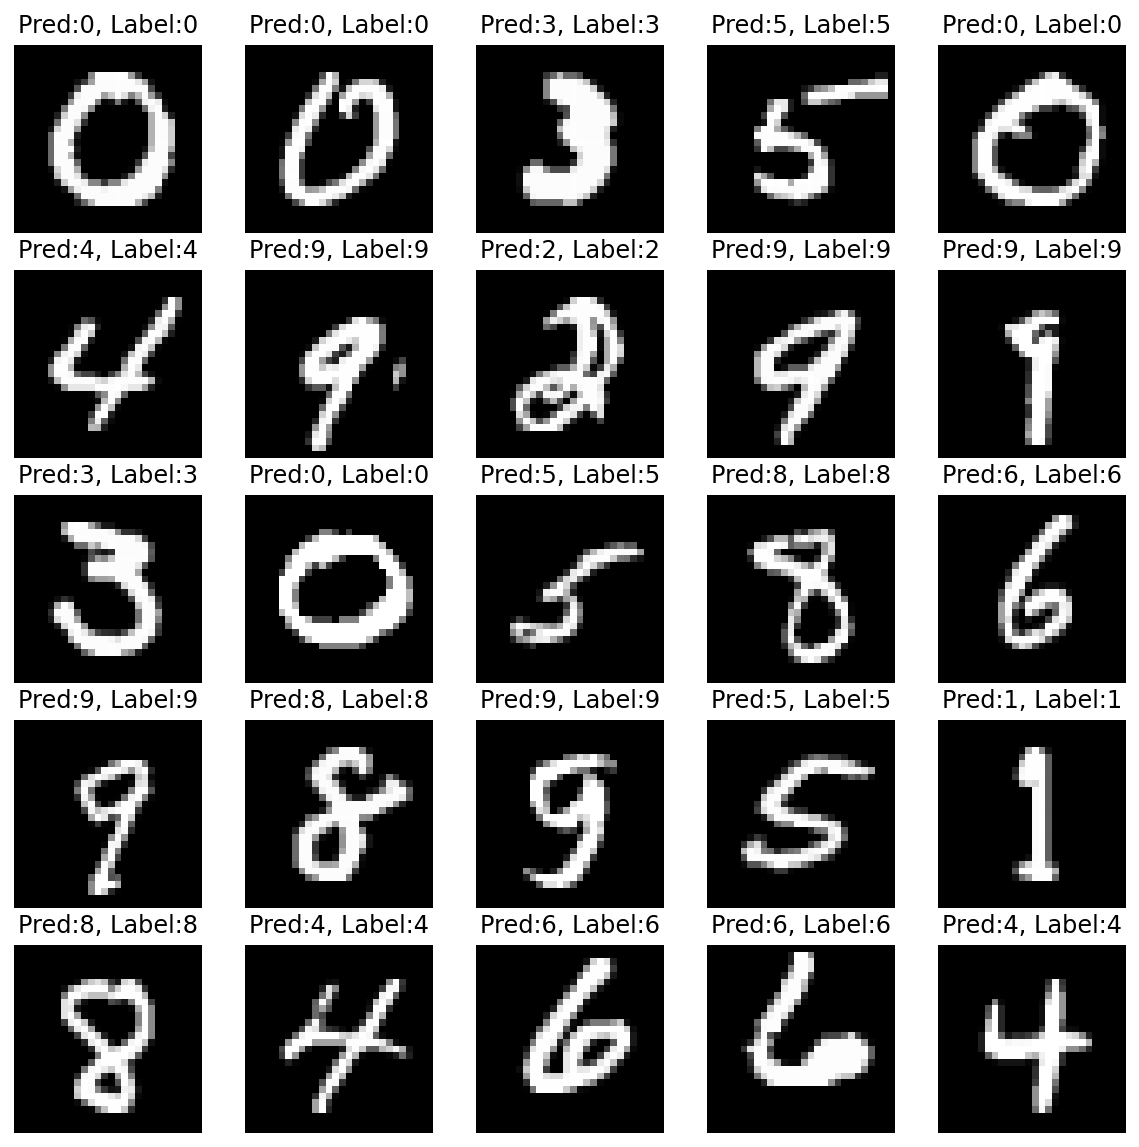

In [ ]:
# test
n_sample = 25
test_iter2 = torch.utils.data.DataLoader(mnist_test, batch_size=n_sample, shuffle=True, num_workers=1)
with torch.no_grad():
    R.eval()
    for batch_in, batch_out in test_iter2 :
        y_target = batch_out.to(device)
        model_pred = R.forward(batch_in.view(-1,28,28).to(device))
        _, y_pred = torch.max(model_pred, 1)
        break
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5,5,idx+1)
    plt.imshow(batch_in[idx,0,:,:], cmap='gray')
    plt.axis('off')
    plt.title(f"Pred:{y_pred[idx]}, Label:{y_target[idx]}")
plt.show()
